## notebook setup
### Import Libraries

In [32]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import pandas as pd


### Define Paths


In [3]:
# Paths to the dataset directories
base_dir = "../../data/medical_images/"
train_dir = os.path.join(base_dir, "train/")
val_dir = os.path.join(base_dir, "val/")
test_dir = os.path.join(base_dir, "test/")

In [4]:

for directory in [test_dir, train_dir, val_dir]:
    if not os.path.exists(directory):
        raise FileNotFoundError(f"{directory} not found. Make sure data preparation is complete.")

## Data Preprocessing
### ImageDataGenerator for the training set

In [16]:
# Image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 16

# Create datasets for training and validation
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)
class_names = train_dataset.class_names
num_classes = len(class_names)
# Apply data augmentation to the training dataset
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

# Apply augmentation to training data
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))

# Prefetch datasets for better performance
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


Found 4094 files belonging to 2 classes.
Found 469 files belonging to 2 classes.
Found 1160 files belonging to 2 classes.


## Build Two Neural Network Architectures
### Simple CNN Model Architecture

This model is a straightforward Convolutional Neural Network (CNN) designed for image classification tasks. It consists of the following layers:

1. **Convolutional Layers:**
   - Two Conv2D layers with ReLU activation:
     - First layer: 32 filters of size `(3, 3)` with input shape defined.
     - Second layer: 64 filters of size `(3, 3)`.

2. **Batch Normalization:**
   - Applied after each convolutional layer to stabilize learning and accelerate training.

3. **Pooling Layers:**
   - Two MaxPooling2D layers with a pool size of `(2, 2)` to downsample the spatial dimensions.

4. **Flattening:**
   - Converts the 2D feature maps into a 1D feature vector.

5. **Fully Connected Layers:**
   - Dense layer with 128 units and ReLU activation.
   - Dropout layer with a rate of 0.5 to prevent overfitting.
   - Output layer with `num_classes` units and a softmax activation for classification.

In [38]:
# Learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    decay_rate=0.9
)

def build_simple_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Build model
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
model1 = build_simple_cnn(input_shape, num_classes)
model1.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model1.summary()


c:\Users\saif\source\ai_project\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,908,034 (91.20 MB)

 Trainable params: 23,907,842 (91.20 MB)

 Non-trainable params: 192 (768.00 B)

### 2. Deep CNN Model Architecture

This deep Convolutional Neural Network (CNN) model is designed for more complex image classification tasks. It features multiple convolutional layers for hierarchical feature extraction, combined with robust regularization techniques.

### Model Architecture

1. **Convolutional Layers:**
   - Three Conv2D layers with ReLU activation:
     - First layer: 32 filters of size `(3, 3)` with input shape defined.
     - Second layer: 64 filters of size `(3, 3)`.
     - Third layer: 128 filters of size `(3, 3)`.

2. **Batch Normalization:**
   - Applied after each convolutional layer to stabilize and accelerate learning.

3. **Pooling Layers:**
   - Three MaxPooling2D layers with a pool size of `(2, 2)` to reduce spatial dimensions.

4. **Global Average Pooling:**
   - Replaces traditional flattening with a `GlobalAveragePooling2D` layer to reduce the risk of overfitting and capture spatial information.

5. **Fully Connected Layers:**
   - Dense layer with 256 units, ReLU activation, and L2 regularization (`kernel_regularizer=l2(0.01)`).
   - Dropout layer with a rate of 0.5 to prevent overfitting.
   - Output layer with `num_classes` units and a softmax activation for classification.

In [34]:
def build_deep_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        GlobalAveragePooling2D(),  # Replace Flatten with GAP
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Build model
model2 = build_deep_cnn(input_shape, num_classes)
model2.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model2.summary()


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,682 (498.76 KB)

 Trainable params: 127,234 (497.01 KB)

 Non-trainable params: 448 (1.75 KB)

## Train the models
### define callbacks

In [40]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',        # Monitor validation loss
    min_delta=0.001,            # Minimum change to qualify as an improvement
    patience=10,               # Wait 10 epochs before stopping
    mode='min',                # Stop when val_loss is no longer decreasing
    restore_best_weights=True  # Revert to the best weights after stopping
)
checkpoint1 = ModelCheckpoint('../../models/medical_image_classification/model1.keras', save_best_only=True, monitor='val_loss')
checkpoint2 = ModelCheckpoint('../../models/medical_image_classification/model2.keras', save_best_only=True, monitor='val_loss')


In [28]:
# hyperparameters
epochs = 30

### train model1

In [36]:
# Train the model
history1 = model1.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[early_stopping, checkpoint1]
)

Loaded existing model from checkpoint
Epoch 1/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 70s 267ms/step - accuracy: 0.7585 - loss: 0.5247 - val_accuracy: 0.7335 - val_loss: 0.5356
Epoch 2/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 74s 289ms/step - accuracy: 0.7530 - loss: 0.5270 - val_accuracy: 0.7356 - val_loss: 0.5788
Epoch 3/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 66s 255ms/step - accuracy: 0.7496 - loss: 0.5302 - val_accuracy: 0.7292 - val_loss: 0.5551
Epoch 4/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 66s 258ms/step - accuracy: 0.7515 - loss: 0.5226 - val_accuracy: 0.7356 - val_loss: 0.5808
Epoch 5/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 66s 256ms/step - accuracy: 0.7554 - loss: 0.5240 - val_accuracy: 0.7356 - val_loss: 0.6466
Epoch 6/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 69s 267ms/step - accuracy: 0.7650 - loss: 0.5220 - val_accuracy: 0.7292 - val_loss: 0.5242
Epoch 7/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 71s 276ms/step - accuracy: 0.7513 - loss: 0.5261 - val_accuracy: 0.7377 - val_loss: 0.5267
Epoch 8/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 79s 3

In [41]:
history2 = model2.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[early_stopping, checkpoint2]
)

Epoch 1/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 216s 845ms/step - accuracy: 0.7471 - loss: 0.5892 - val_accuracy: 0.7292 - val_loss: 7.7937
Epoch 2/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 114s 445ms/step - accuracy: 0.7477 - loss: 0.5596 - val_accuracy: 0.7292 - val_loss: 0.5595
Epoch 3/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 120s 467ms/step - accuracy: 0.7505 - loss: 0.5611 - val_accuracy: 0.7292 - val_loss: 0.5766
Epoch 4/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 118s 459ms/step - accuracy: 0.7503 - loss: 0.5534 - val_accuracy: 0.7292 - val_loss: 0.6711
Epoch 5/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 118s 461ms/step - accuracy: 0.7490 - loss: 0.5649 - val_accuracy: 0.7292 - val_loss: 0.5414
Epoch 6/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 112s 438ms/step - accuracy: 0.7529 - loss: 0.5520 - val_accuracy: 0.7313 - val_loss: 0.5479
Epoch 7/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 141s 550ms/step - accuracy: 0.7478 - loss: 0.5563 - val_accuracy: 0.7292 - val_loss: 0.5643
Epoch 8/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 183s 715ms/step - accuracy: 0.7519 -

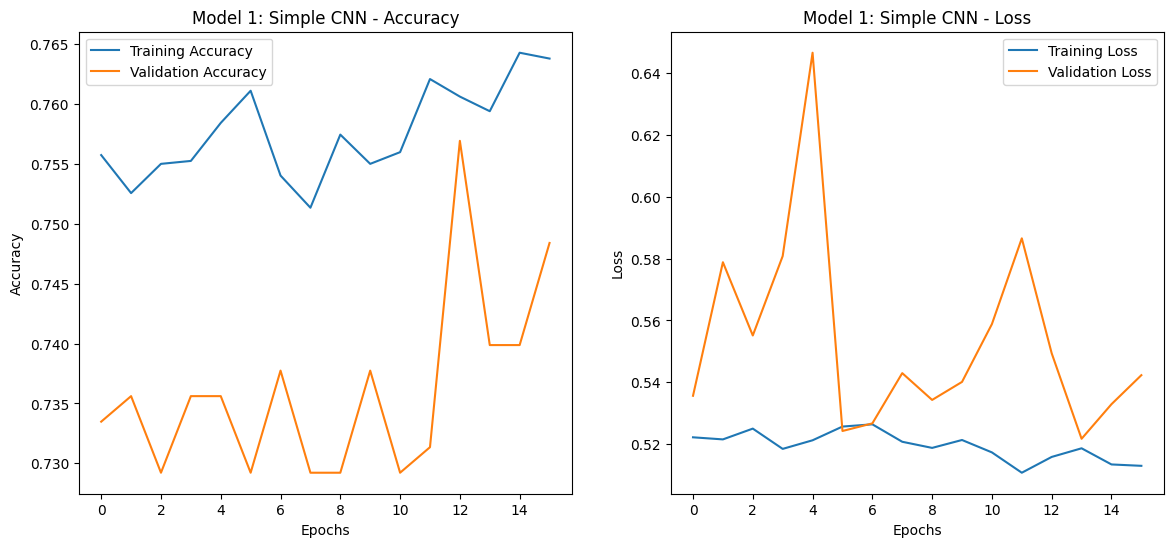

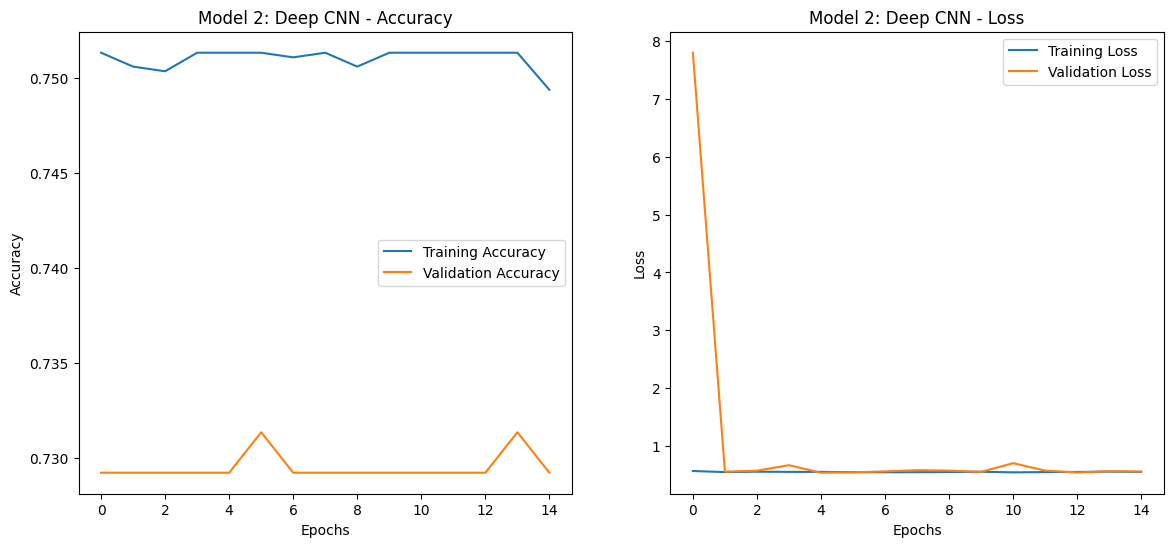

In [42]:
def plot_training_metrics(history, title):
    # Plot accuracy and loss over epochs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{title} - Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{title} - Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.show()

# Plot metrics for both models
plot_training_metrics(history1, "Model 1: Simple CNN")
plot_training_metrics(history2, "Model 2: Deep CNN")


In [35]:
# Save class indices mapping
import json
class_indices_path = os.path.join("../../models/medical_image_classification", "class_indices.json")
with open(class_indices_path, 'w') as f:
    json.dump(train_generator.class_indices, f)

print("Class indices saved:", train_generator.class_indices)


Class indices saved: {'0': 0, '1': 1}


**Summary:**
- Trained two different CNN architectures:
  - Model 1: Simple CNN with fewer layers.
  - Model 2: Deep CNN with batch normalization.
- Early stopping and checkpoints were used to save the best-performing models.
- Training and validation metrics were plotted to visualize performance.

**Next Steps:**
- Proceed to `4_model_evaluation.ipynb` to evaluate the models on the test set and compare their performance.
